# Fine-tune BLIP using Hugging Face `transformers` and `datasets` 🤗

This tutorial is largely based from the [GiT tutorial](https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing) on how to fine-tune GiT on a custom image captioning dataset. Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions.
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
!export CUDA_VISIBLE_DEVICES='1'

import torch
torch.cuda.device_count()

1

In [2]:
from datasets import load_dataset, Dataset
from PIL import Image
import pandas as pd

/data/vkarlov/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# dataset = load_dataset('json', data_files='lora_dataset.json')

In [4]:
dataset = Dataset.from_pandas(pd.read_csv('/data/vkarlov/robotics/LLaVA/train_v1.tsv', sep='\t').rename(columns={'goal' : 'question', 'text' : 'answer'}))

In [5]:
dataset[0]

{'plan_id': 0,
 'question': 'How would you put the orange kitten in the green box?',
 'image': '/data/vkarlov/robotics/train_dataset/train_images/-9537287721930320_0.png',
 'answer': '1. move_to("unspecified", "orange kitten"), 2. pick_up("unspecified", "orange kitten"), 3. move_to("green box", "orange kitten"), 4. put("green box", "orange kitten"), 5. done().'}

Let's retrieve the caption of the first example:

And the corresponding image

## Create PyTorch Dataset

The lines below are entirely copied from the original notebook!

In [6]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = Image.open(item['image']).convert('RGB')
        
        inputs = self.processor(images=image, text=item["question"], padding="max_length", return_tensors="pt")
        labels = self.processor(text=item['answer'], padding="max_length", return_tensors="pt").input_ids
        inputs["labels"] = labels
        
        # remove batch dimension
        inputs = {k:v.squeeze() for k,v in inputs.items()}
        return inputs

In [31]:
dataset[0]

{'plan_id': 0,
 'question': 'How would you put the orange kitten in the green box?',
 'image': '/data/vkarlov/robotics/train_dataset/train_images/-9537287721930320_0.png',
 'answer': '1. move_to("unspecified", "orange kitten"), 2. pick_up("unspecified", "orange kitten"), 3. move_to("green box", "orange kitten"), 4. put("green box", "orange kitten"), 5. done().'}

## Load model and processor

In [7]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-vqa-base")

2023-10-15 09:51:18.966006: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-15 09:51:19.013787: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 09:51:20.014263: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
for param in model.text_decoder.bert.parameters():
    param.requires_grad = False
    
for param in model.vision_model.embeddings.parameters():
    param.requires_grad = False    

In [9]:
model.vision_model.embeddings

BlipVisionEmbeddings(
  (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
)

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [10]:
BATCH_SIZE = 32

train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)

## Train the model

Let's train the model! Run the simply the cell below for training the model

In [11]:
import torch
from tqdm.auto import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  progress_bar = tqdm(train_dataloader)
  
  for idx, batch in enumerate(progress_bar):
    inputs = {k:v.cuda() for k,v in batch.items()}
    outputs = model(**inputs)

    loss = outputs.loss
    progress_bar.set_description("Loss = {:.4f}".format(loss.item()))

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 0


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 4


Loss = 5.7926: 100%|██████████| 8/8 [00:17<00:00,  2.13s/it]


## Inference

Let's check the results on our train dataset

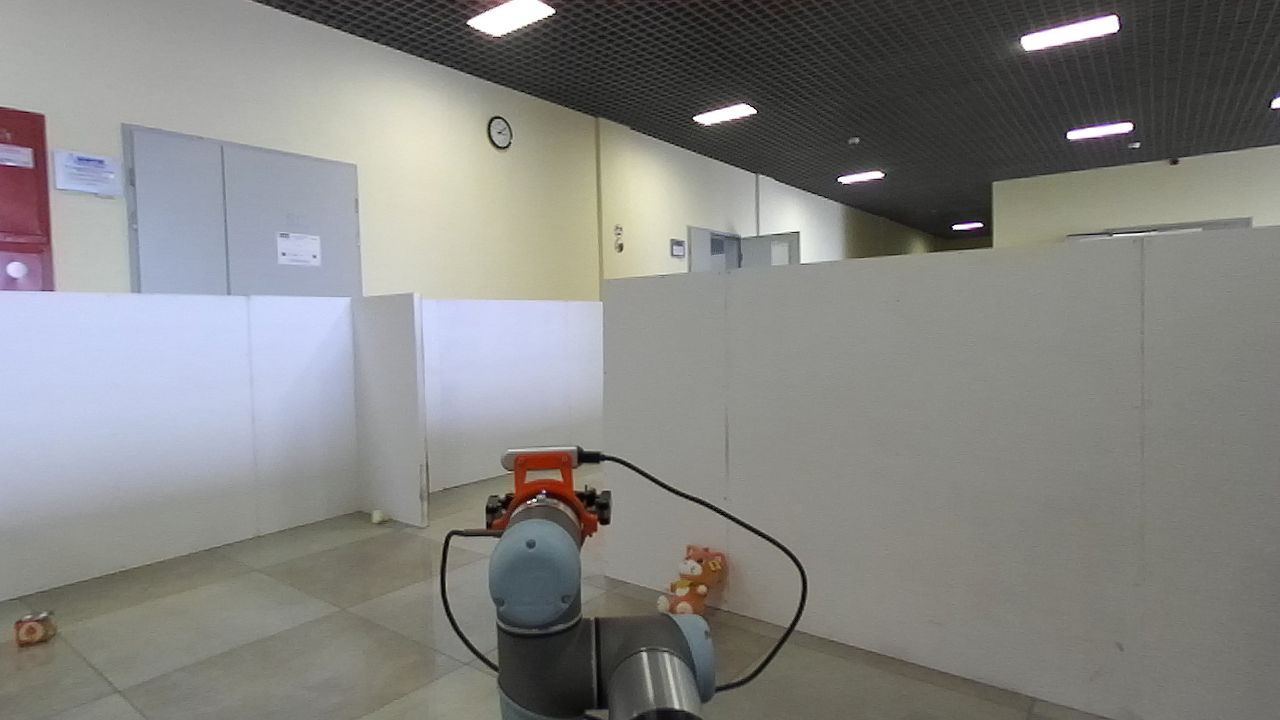

In [13]:
# load image
example = dataset[0]
image = Image.open(example['image']).convert('RGB')
image

In [20]:
example['image']

'/data/vkarlov/robotics/train_dataset/train_images/-9537287721930320_0.png'

In [25]:
train_dataset[0]

{'pixel_values': tensor([[[ 0.5581,  0.5873,  0.5727,  ..., -1.0331, -0.9602, -0.8726],
          [ 0.5873,  0.5727,  0.5873,  ..., -1.1353, -1.0039, -0.9602],
          [ 0.6019,  0.5873,  0.5727,  ..., -1.1499, -0.9310, -0.9748],
          ...,
          [-0.1280, -0.1134, -0.0988,  ..., -0.1864, -0.1718, -0.1718],
          [-0.0842, -0.0696, -0.0842,  ..., -0.1864, -0.2156, -0.2156],
          [-0.0842, -0.0550, -0.0842,  ..., -0.1718, -0.2010, -0.2156]],
 
         [[ 0.6642,  0.6942,  0.6792,  ..., -0.9717, -0.8967, -0.8066],
          [ 0.6942,  0.6792,  0.6942,  ..., -1.0767, -0.9417, -0.8967],
          [ 0.7092,  0.6942,  0.6792,  ..., -1.0918, -0.8666, -0.9117],
          ...,
          [-0.0862, -0.0712, -0.0562,  ..., -0.1163, -0.1012, -0.1012],
          [-0.0412, -0.0262, -0.0412,  ..., -0.1163, -0.1463, -0.1463],
          [-0.0412, -0.0112, -0.0412,  ..., -0.1012, -0.1313, -0.1463]],
 
         [[ 0.7808,  0.8092,  0.7950,  ..., -0.7692, -0.6981, -0.6128],
          [ 

In [30]:
# prepare image for the model
# inputs = {k:v.cuda() for k,v in inputs.items()}
inputs = {k:v.unsqueeze(0).cuda() for k,v in train_dataset[0].items()}
print(inputs)
outputs = model.generate(**inputs)

print(processor.decode(outputs[0], skip_special_tokens=True))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


{'pixel_values': tensor([[[[ 0.5581,  0.5873,  0.5727,  ..., -1.0331, -0.9602, -0.8726],
          [ 0.5873,  0.5727,  0.5873,  ..., -1.1353, -1.0039, -0.9602],
          [ 0.6019,  0.5873,  0.5727,  ..., -1.1499, -0.9310, -0.9748],
          ...,
          [-0.1280, -0.1134, -0.0988,  ..., -0.1864, -0.1718, -0.1718],
          [-0.0842, -0.0696, -0.0842,  ..., -0.1864, -0.2156, -0.2156],
          [-0.0842, -0.0550, -0.0842,  ..., -0.1718, -0.2010, -0.2156]],

         [[ 0.6642,  0.6942,  0.6792,  ..., -0.9717, -0.8967, -0.8066],
          [ 0.6942,  0.6792,  0.6942,  ..., -1.0767, -0.9417, -0.8967],
          [ 0.7092,  0.6942,  0.6792,  ..., -1.0918, -0.8666, -0.9117],
          ...,
          [-0.0862, -0.0712, -0.0562,  ..., -0.1163, -0.1012, -0.1012],
          [-0.0412, -0.0262, -0.0412,  ..., -0.1163, -0.1463, -0.1463],
          [-0.0412, -0.0112, -0.0412,  ..., -0.1012, -0.1313, -0.1463]],

         [[ 0.7808,  0.8092,  0.7950,  ..., -0.7692, -0.6981, -0.6128],
          [ 0

/data/vkarlov/venv/lib/python3.10/site-packages/transformers/generation/utils.py:1254: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/data/vkarlov/venv/lib/python3.10/site-packages/transformers/generation/utils.py:1262: UserWarning: Input length of input_ids is 511, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


## Load from the Hub

Once trained you can push the model and processor on the Hub to use them later.
Meanwhile you can play with the model that we have fine-tuned!

In [ ]:
from transformers import BlipForConditionalGeneration, AutoProcessor

model = BlipForConditionalGeneration.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned").to(device)
processor = AutoProcessor.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned")

Downloading:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/990M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/431 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/488 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/712k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Let's check the results on our train dataset!

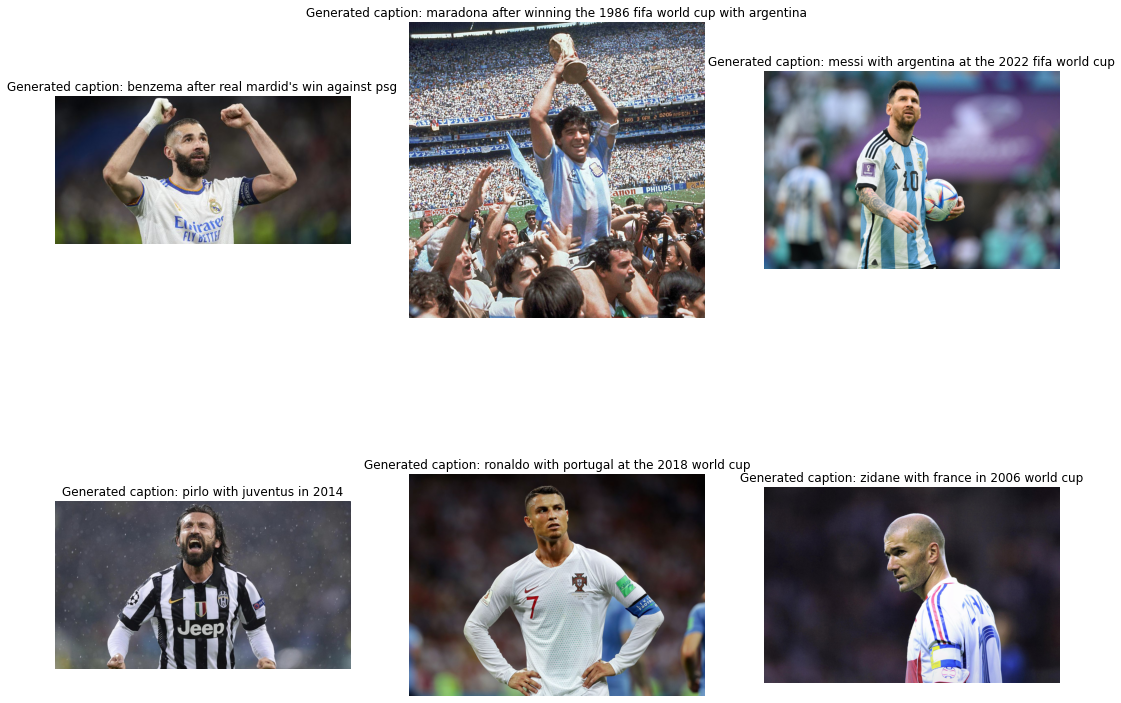

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")